# Current through a molecule

In this notebook I will investigate:
- how current passes through a molecule under some electronic potential, effects of lead non-additivity
- how photocurrent is induced when the molecule is incident to a (hot) thermal electromagnetic environment
- The effects of lead and phonon non-additivity on photocurrent


In [51]:
import time
import numpy as np

import matplotlib.pyplot as plt
import qutip as qt
import scipy as sp


import fermionic_leads as fl

import UD_liouv as RC
import driving_liouv as EM

import phonon_weak_coupling as WC

from qutip import ket, basis, sigmam, sigmap, spre, sprepost, spost, destroy, mesolve, tensor, qeye
from numpy import pi, linspace
from fermionic_leads import non_additive_lead_dissipator, additive_lead_dissipator, current_from_L
from utils import J_overdamped, beta_f, J_underdamped, J_minimal_hard, J_multipolar
from utils import ground_and_excited_states, initialise_TLS

## First: current-voltage diagrams in absence of phonons

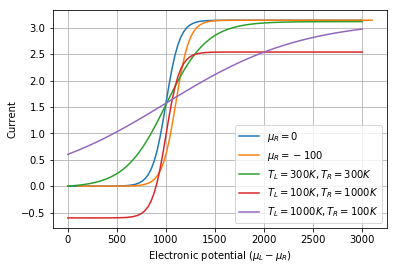

In [43]:
reload(fl)
kB = 0.695
d = destroy(2)
ddag = d.dag()

sigma = ket([0])*ket([1]).dag()

E = basis(2,1)*basis(2,1).dag()
G = basis(2,0)*basis(2,0).dag()

eps = 1000
mu = 100
T = 100
Gamma_l = 1.
H = eps*E

def simple_current_noise(eps, T_L, T_R, mu_R):
    mu_Ls = np. linspace(0, 3000, 100)
    currents = []
    for mu_L in mu_Ls:
        L_L = non_additive_lead_dissipator(H, d, eps, T_L, mu_L, Gamma)
        L_R = non_additive_lead_dissipator(H, d, eps, T_R, mu_R, Gamma)
        currents.append(current_from_L(H, L_L+L_R, L_R, E))
    return mu_Ls-mu_R, currents

v1, c1 = simple_current_noise(eps, T, T, 0)
v2, c2 = simple_current_noise(eps, T, T, -100)
v3, c3 = simple_current_noise(eps, 300., 300., 0)
v4, c4 = simple_current_noise(eps, 100., 1000., 0) 
v5, c5 = simple_current_noise(eps, 1000., 100., 0)
plt.plot(v1, c1, label='$\mu_R=0$')
plt.plot(v2, c2, label='$\mu_R=-100$')
plt.plot(v3, c3, label='$T_L=300K, T_R=300K$')
plt.plot(v4, c4, label='$T_L=100K, T_R=1000K$')
plt.plot(v5, c5, label='$T_L=1000K, T_R=100K$')
plt.xlabel("Electronic potential ($\mu_L-\mu_R$)")
plt.ylabel("Current")
plt.grid()
plt.legend()
plt.show()

The normal current-voltage relations are reproduced:
- A saddle-point at the TLS transition energy
- A shift in the x-axis as the bias window spans different sections/proportions of the TLS energy gap
- Squashed in y-direction for increasing temperature - equilibrium population is higher so needs higher gradient to move - current in high-bias limit is temperature independent
- If there is a thermal gradient against current, there can be backward thermoelectric current at low enough bias (?)
- Opposite is true for positive thermal gradient, though the overall current is lower in high-bias regime

## Phonons and leads

Here I'll investigate current-voltage relations when including phonons. The exact same plots as above but with a single mode with a couple of different parameters.

20
0.0 % complete
20.0 % complete
40.0 % complete
60.0 % complete
80.0 % complete
20
0.0 % complete
20.0 % complete
40.0 % complete
60.0 % complete
80.0 % complete
10
0.0 % complete
20.0 % complete
40.0 % complete
60.0 % complete
80.0 % complete


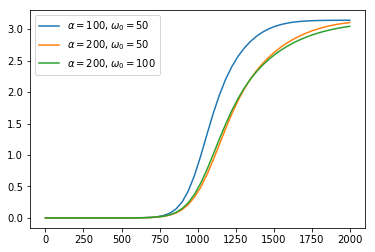

In [94]:
reload(fl)
Gamma_l = 1.
ti = time.time()
T_ph = 100.
N = 20
T_EM=0.
J_EM=J_multipolar
init_sys = G
init_RC = 0
Gamma, w0, alpha_ph, Gamma_EM = 10., 50., 100./pi, 1.
d_RC = tensor(d, qeye(N))
E_RC = tensor(E, qeye(N))
L_RC, H_RC, A_EM, A_nrwa, Z, _, _, _, = RC.RC_function_UD(sigma, eps, T_ph, Gamma, w0, alpha_ph, 
                                                         N, silent=True)
# Three different approaches
L_full = EM.L_non_rwa(H_RC, A_nrwa, eps, Gamma_EM, T_EM, J=J_EM, silent=True)
L_add = EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T_EM, J_EM, silent=True)
#timelist = np.linspace(0, 3/Gamma_EM, 360)
L = [L_nrwa, L_esa]

#expects = [tensor(E*E.dag(), qeye(N)), tensor(E*G.dag()+G*E.dag(), qeye(N))]
#rho_0 = initialise_TLS(init_sys, init_RC, H_RC.eigenstates()[1], w0, T_ph, H_RC=H_RC)

opts = qt.Options(nsteps=1000)
T_L, T_R, mu_R, mu_L = 100, 100.,0.,1000.
L_L = non_additive_lead_dissipator(H_RC, d_RC, eps, T_L, mu_L, Gamma_l)
L_R = non_additive_lead_dissipator(H_RC, d_RC, eps, T_R, mu_R, Gamma_l)
L_leads = L_L + L_R
"""DATA_full = mesolve(H_RC, rho_0, timelist, [L_RC+L_leads+L_full], 
                              expects, options=opts)
DATA_add = mesolve(H_RC, rho_0, timelist, [L_RC+L_leads+L_add], 
                              expects, options=opts)
plt.plot(timelist, DATA_full.expect[0])
plt.plot(timelist, DATA_add.expect[0])
plt.show()
"""

def current_noise_with_phonons(eps, T_ph, Gamma, w0, alpha_ph, N, T_L=77., T_R=77., mu_R=0.):
    mu_Ls = np. linspace(0, 2000, 50)
    print eps/w0
    currents = []
    d_RC = tensor(d, qeye(N))
    E_RC = tensor(E, qeye(N))
    L_RC, H_RC, A_EM, A_nrwa, Z, _, _, _, = RC.RC_function_UD(sigma, eps, T_ph, Gamma, w0, alpha_ph, 
                                                         N, silent=True)
    
    #timelist = np.linspace(0, 3/Gamma_EM, 360)
    for i, mu_L in enumerate(mu_Ls):
        L_L, L_R = fl.L_R_lead_dissipators(H_RC, d_RC, eps, T_L, mu_L, Gamma_l, T_R, mu_R, Gamma_l)
        currents.append(current_from_L(H_RC, L_RC+L_L+L_R, L_R, E_RC))
        if (i%10)==0:
            print 100*(float(i)/len(mu_Ls)), "% complete"
    return mu_Ls-mu_R, currents

c1, v1 = current_noise_with_phonons(1000, 77., Gamma, 50, 100, N, T_L=77., T_R=77., mu_R=0.)
c2, v2 = current_noise_with_phonons(1000, 77., Gamma, 50, 200, N, T_L=77., T_R=77., mu_R=0.)
c3, v3 = current_noise_with_phonons(1000, 77., Gamma, 100, 200, N, T_L=77., T_R=77., mu_R=0.)

plt.plot(c1, v1, label=r'$\alpha=100, \omega_0=50$')
plt.plot(c2, v2, label=r'$\alpha=200, \omega_0=50$')
plt.plot(c3, v3, label=r'$\alpha=200, \omega_0=100$')
plt.legend()
plt.show()

## Photocurrent